In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import os, fnmatch
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures 
import seaborn as sns
%matplotlib inline
from keras.layers import Input, Dense
from keras.models import Model
# from keras.op
from keras import optimizers
from keras import regularizers
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
all_tiff_files = []
listOfFiles = os.listdir('./clean_data/obj_test_res/')
pattern = "*.tiff"
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            all_tiff_files.append('./clean_data/obj_test_res/'+entry)

In [3]:
print(len(all_tiff_files))

42010


In [4]:
images_list = []
half_size = int(len(all_tiff_files) / 2)
max_size = 0
max_width = 0
max_height = 0
ind = 0
for i in range(half_size):
#    if(i == 25232):
#        print(all_tiff_files[i])
    im = Image.open(all_tiff_files[i])
    arr = np.array(im)#.flatten()
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list.append(arr)

for i in range(half_size, len(all_tiff_files)):
#    if(i == 25232):
#        print(all_tiff_files[i])
    im = Image.open(all_tiff_files[i])
    arr = np.array(im)#.flatten()
    arr=(arr-arr.min())/(arr.max()-arr.min())
    #arr = arr / 0xffff
    s = arr.shape
    if s[0] > max_height:
        max_height = s[0]
    if s[1] > max_width:
        max_width = s[1]
        ind = i
    images_list.append(arr)   

In [5]:
print(max_width, max_height, max_size)
#print(images_list[0])

27 140 0


In [6]:
#for i in range(len(images_list)):
#    diff = max_size - len(images_list[i])
#    half_1 = int(diff / 2)
#    half_2 = diff - half_1
#    front_arr = np.zeros(half_1)
#    back_arr = np.zeros(half_2)
#    images_list[i] = np.insert(images_list[i], 0, front_arr, axis=0)
#    images_list[i] = np.insert(images_list[i], len(images_list[i] - 1), back_arr, axis=0)

In [6]:
for i in range(len(images_list)):
    s = images_list[i].shape
    d_width = (max_width - s[1])
    d_height = (max_height - s[0])
    
    d_top = int(d_height / 2)
    d_bottom = int(d_height - d_top)
    
    d_left = int(d_width / 2)
    d_right = int(d_width - d_left)
    #print(d_top, d_bottom, d_left, d_right)
    
    arr = images_list[i]
    for l in range(d_left):
        arr = np.insert(arr, 0, 0, axis = 1)
    
    for r in range(d_right):
        b = np.zeros((s[0],1))
        arr = np.append(arr, b, axis = 1)
    
    for t in range(d_top):
        arr = np.insert(arr, 0, 0, axis = 0)
    
    for b in range(d_bottom):
        b = np.zeros((1, arr.shape[1],))
        arr = np.append(arr, b, axis = 0)
    
    images_list[i] = arr.flatten()

27 140


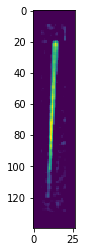

In [7]:
width = max_width
height = max_height
print(width, height)
plt.imshow(images_list[253].reshape(140,27))

In [8]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
print(device_lib.list_local_devices())

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10673766383875634604
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1441641267
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17645937156624546031
physical_device_desc: "device: 0, name: GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [9]:
images_np = np.array(images_list)
file_names_np = np.array(all_tiff_files)
#df = pd.DataFrame(images_np)
#df["file_name"] = file_names_np
#df.head()
#from sklearn.decomposition import PCA
#pca = PCA(.98)
#principalComponents = pca.fit_transform(images_np)

In [10]:
images_np.shape

(42010, 3780)

In [11]:
X_train, X_test = train_test_split(images_np, test_size=0.2, random_state=100)

In [12]:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (33608, 3780)
33608 train samples
8402 test samples


In [13]:
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout
inpu_dim = X_train.shape[1]
h_1 = 2048
h_2 = 1024
h_3 = 256
h_4 = 64
encoding_dim = 16

input_vect = Input(shape = (inpu_dim,))
x = BatchNormalization()(input_vect)
#x = Dropout(0.5)(x)
x = Dense(h_1, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(h_2, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(h_3, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(h_4, activation="relu", kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation="relu")(x)

x = BatchNormalization()(encoded)
#x = Dropout(0.5)(x)
x = Dense(h_4, activation="relu", kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dense(h_3, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(h_2, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(h_1, activation="relu")(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
decoded = Dense(inpu_dim, activation="relu")(x)

autoencoder = Model(input_vect, decoded)
encoder = Model(input_vect, encoded)

In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3780)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3780)              15120     
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              7743488   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
__________

In [15]:
adadelta = optimizers.Adadelta(lr=0.5, rho=0.95)

In [16]:
#autoencoder.compile(optimizer="adadelta", loss = "MSE",metrics=['mean_squared_error'])

#sgd = keras.optimizers.SGD(lr=0.5, momentum=0.01)
#autoencoder.compile(loss='kld', optimizer=sgd, metrics=['accuracy'])

autoencoder.compile(optimizer=adadelta , loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [60]:
history = autoencoder.fit(X_train, X_train, epochs = 20, batch_size = 512, shuffle=True, validation_data=(X_test, X_test))

Train on 33608 samples, validate on 8402 samples
Epoch 1/20
33608/33608 [==============================] - 12s 355us/step - loss: 0.0891 - acc: 0.8726 - val_loss: 0.0970 - val_acc: 0.8713
Epoch 2/20
33608/33608 [==============================] - 12s 353us/step - loss: 0.0918 - acc: 0.8726 - val_loss: 0.0935 - val_acc: 0.8715
Epoch 3/20
33608/33608 [==============================] - 12s 357us/step - loss: 0.0869 - acc: 0.8727 - val_loss: 0.0896 - val_acc: 0.8717
Epoch 4/20
33608/33608 [==============================] - 12s 356us/step - loss: 0.0869 - acc: 0.8728 - val_loss: 0.0955 - val_acc: 0.8715
Epoch 5/20
33608/33608 [==============================] - 12s 360us/step - loss: 0.0896 - acc: 0.8728 - val_loss: 0.0983 - val_acc: 0.8713
Epoch 6/20
33608/33608 [==============================] - 12s 357us/step - loss: 0.0864 - acc: 0.8727 - val_loss: 0.0885 - val_acc: 0.8716
Epoch 7/20
33608/33608 [==============================] - 12s 358us/step - loss: 0.0865 - acc: 0.8727 - val_loss: 0.0

In [37]:
plt.plot(history.history['mean_squared_error'], label='MSE (train data)')
plt.plot(history.history['val_mean_squared_error'], label='MSE (val data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

KeyError: 'accuracy'

In [61]:
encoded_values = encoder.predict(images_np)
decoded_values = autoencoder.predict(images_np)

In [62]:
decoded_values.shape

(42010, 3780)

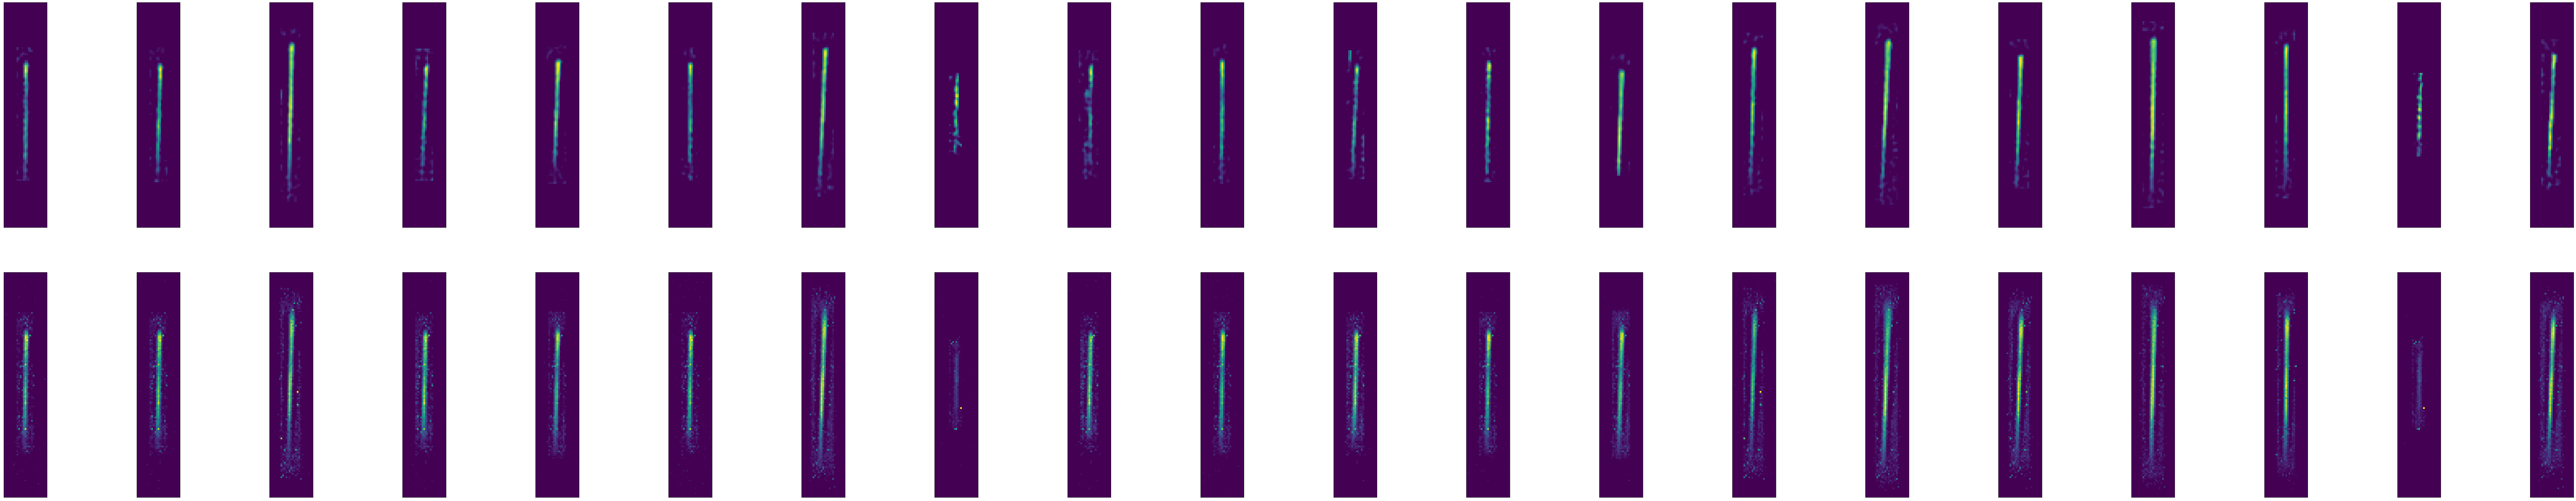

In [63]:
n = 20
plt.figure(figsize = (140,27))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images_np[i].reshape(140,27))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_values[i].reshape(140,27))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [64]:
encoded_df = pd.DataFrame(encoded_values)
encoded_df["file_name"] = all_tiff_files
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,file_name
0,2.459416,0.000000,0.450143,0.333930,0.000000,0.264795,0.549866,3.695076,0.000000,0.000000,0.000000,0.551492,0.000000,0.000000,0.440701,0.000000,./clean_data/obj_test_res/fbs2021_1000.tiff
1,2.082685,0.000000,0.466021,0.000000,0.000000,0.714515,0.545210,3.028279,0.000000,0.000000,0.000000,0.468333,0.000000,0.000000,0.090469,0.000000,./clean_data/obj_test_res/fbs2021_1001.tiff
2,0.000000,0.415509,0.369432,0.010286,1.598568,0.000000,0.234160,0.000000,4.084668,0.830958,0.000000,0.000000,4.072865,0.764828,3.128819,0.000000,./clean_data/obj_test_res/fbs2021_1002.tiff
3,1.747927,0.000000,0.506964,0.000000,0.000000,1.040100,0.445160,2.436463,0.000000,0.000000,0.081713,0.398069,0.000000,0.000000,0.000000,0.000000,./clean_data/obj_test_res/fbs2021_1003.tiff
4,1.613413,0.000000,0.307935,1.835617,0.211364,0.029829,0.024312,3.137597,0.000000,0.000000,0.000000,0.164668,0.000000,0.000000,0.000000,0.040512,./clean_data/obj_test_res/fbs2021_1004.tiff


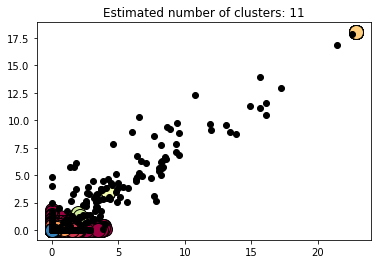

In [249]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X = encoded_values
db = DBSCAN(eps=0.8, min_samples=3).fit(encoded_values)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [55]:
import sklearn
sklearn.metrics.silhouette_score(encoded_values, labels, metric='euclidean', sample_size=None, random_state=None)

-0.40545556

In [ ]:
def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

In [208]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(encoded_values)

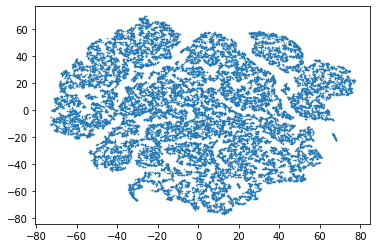

In [213]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s = 0.1)

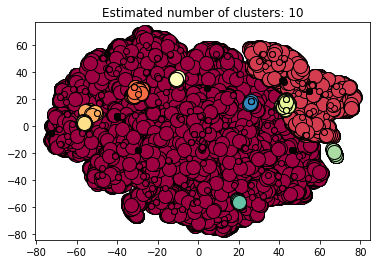

In [217]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X = X_embedded
db = DBSCAN(eps=1.5, min_samples=10).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [47]:
import sklearn
sklearn.metrics.silhouette_score(X_embedded, labels, metric='euclidean', sample_size=None, random_state=None)

-0.5162359

In [67]:
print(len(db.labels_))

42010


In [247]:
x = db.labels_
unique, counts = np.unique(x, return_counts=True)
print((np.asarray((unique, counts)).T)[569])

[568   9]


In [227]:
encoded_df['labels'] = x

In [244]:
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,file_name,labels
0,2.459416,0.000000,0.450143,0.333930,0.000000,0.264795,0.549866,3.695076,0.000000,0.000000,0.000000,0.551492,0.000000,0.000000,0.440701,0.000000,./clean_data/obj_test_res/fbs2021_1000.tiff,0
1,2.082685,0.000000,0.466021,0.000000,0.000000,0.714515,0.545210,3.028279,0.000000,0.000000,0.000000,0.468333,0.000000,0.000000,0.090469,0.000000,./clean_data/obj_test_res/fbs2021_1001.tiff,0
2,0.000000,0.415509,0.369432,0.010286,1.598568,0.000000,0.234160,0.000000,4.084668,0.830958,0.000000,0.000000,4.072865,0.764828,3.128819,0.000000,./clean_data/obj_test_res/fbs2021_1002.tiff,0
3,1.747927,0.000000,0.506964,0.000000,0.000000,1.040100,0.445160,2.436463,0.000000,0.000000,0.081713,0.398069,0.000000,0.000000,0.000000,0.000000,./clean_data/obj_test_res/fbs2021_1003.tiff,0
4,1.613413,0.000000,0.307935,1.835617,0.211364,0.029829,0.024312,3.137597,0.000000,0.000000,0.000000,0.164668,0.000000,0.000000,0.000000,0.040512,./clean_data/obj_test_res/fbs2021_1004.tiff,0


In [245]:
df_files = encoded_df[encoded_df['labels'] == 0]

In [246]:
df_files.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,file_name,labels


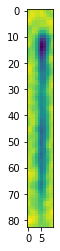

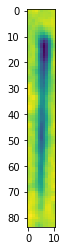

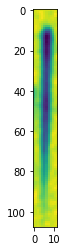

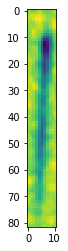

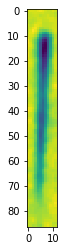

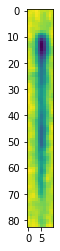

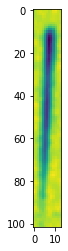

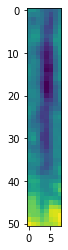

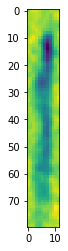

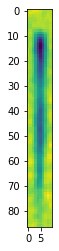

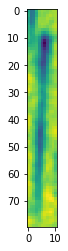

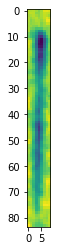

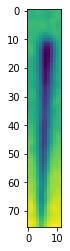

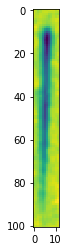

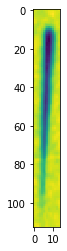

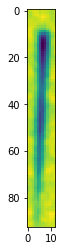

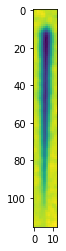

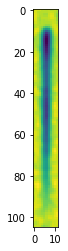

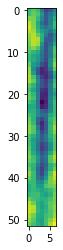

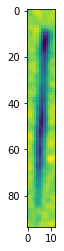

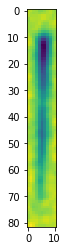

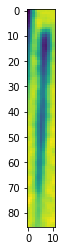

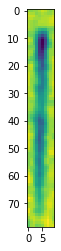

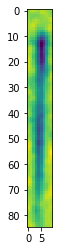

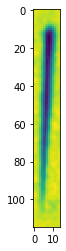

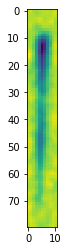

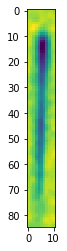

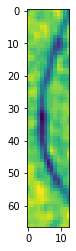

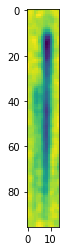

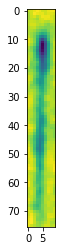

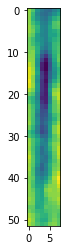

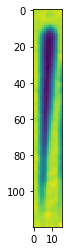

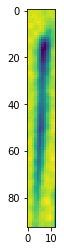

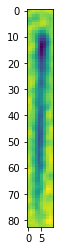

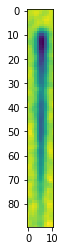

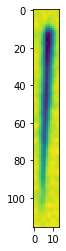

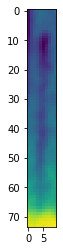

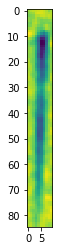

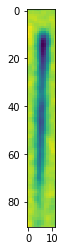

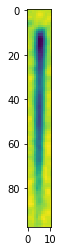

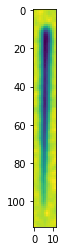

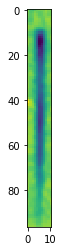

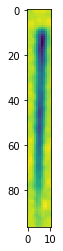

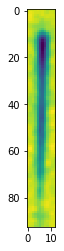

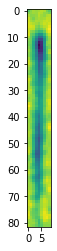

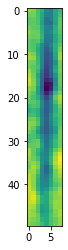

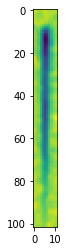

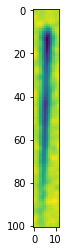

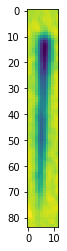

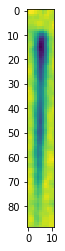

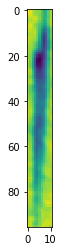

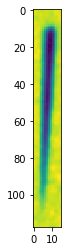

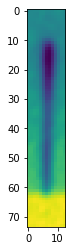

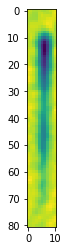

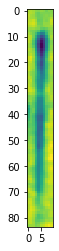

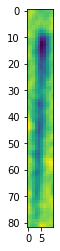

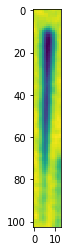

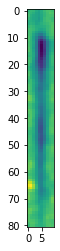

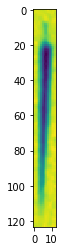

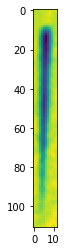

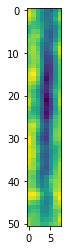

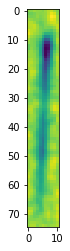

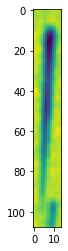

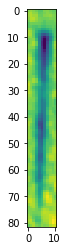

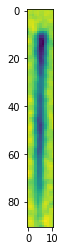

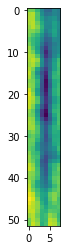

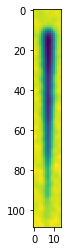

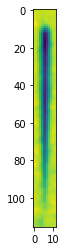

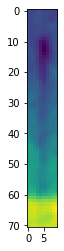

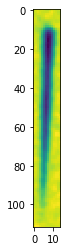

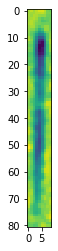

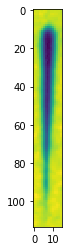

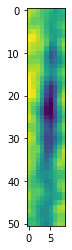

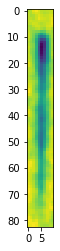

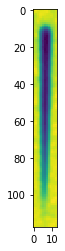

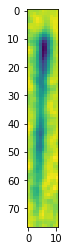

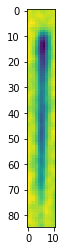

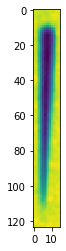

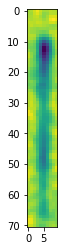

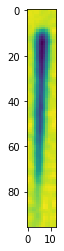

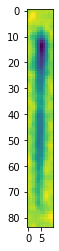

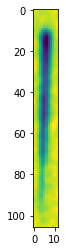

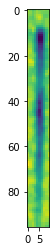

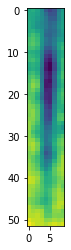

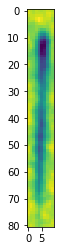

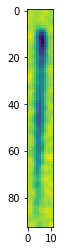

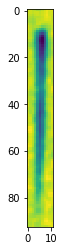

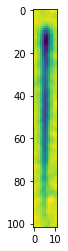

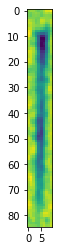

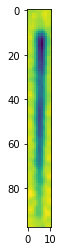

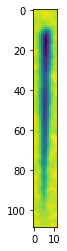

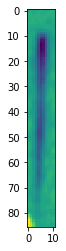

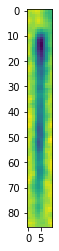

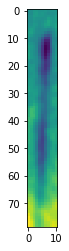

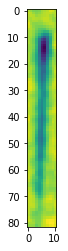

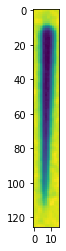

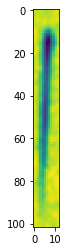

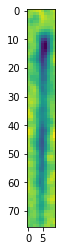

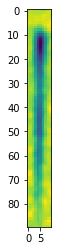

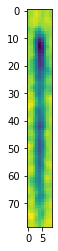

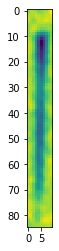

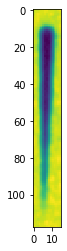

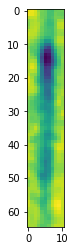

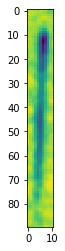

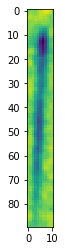

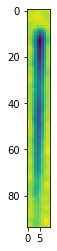

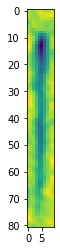

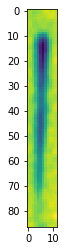

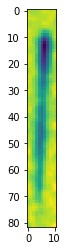

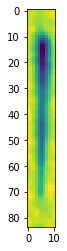

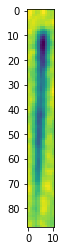

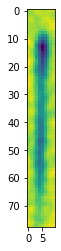

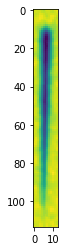

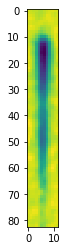

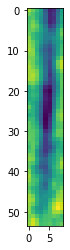

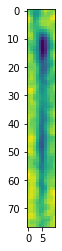

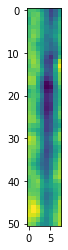

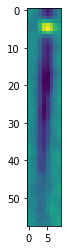

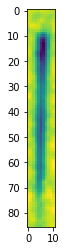

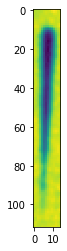

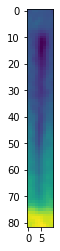

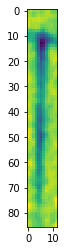

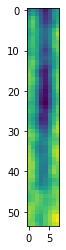

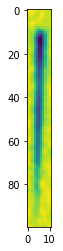

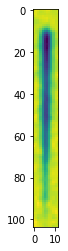

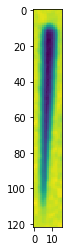

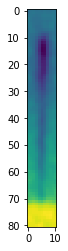

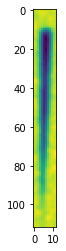

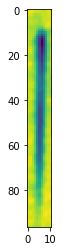

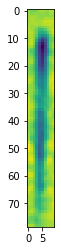

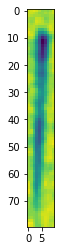

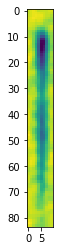

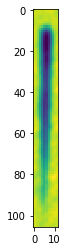

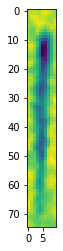

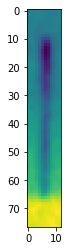

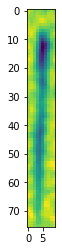

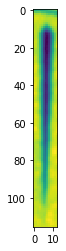

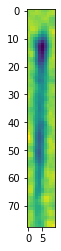

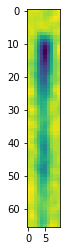

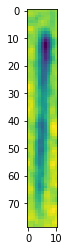

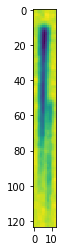

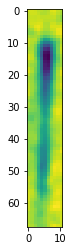

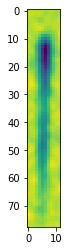

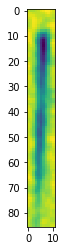

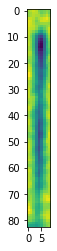

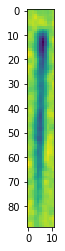

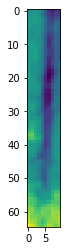

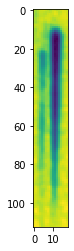

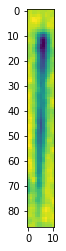

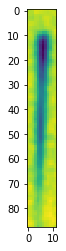

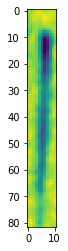

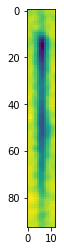

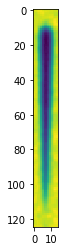

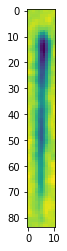

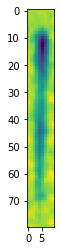

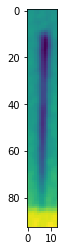

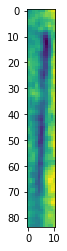

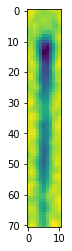

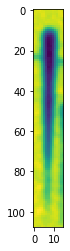

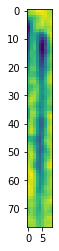

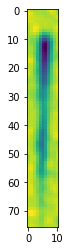

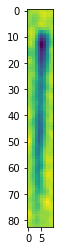

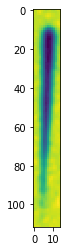

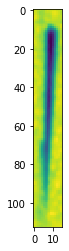

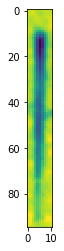

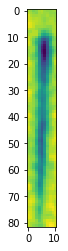

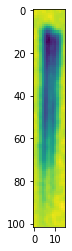

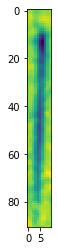

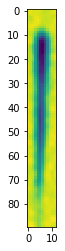

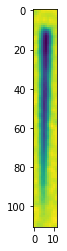

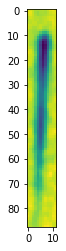

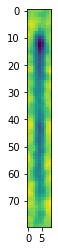

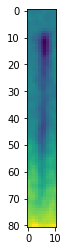

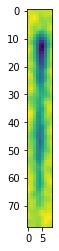

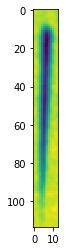

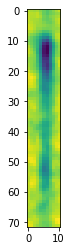

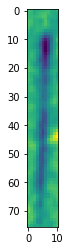

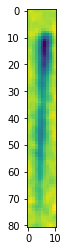

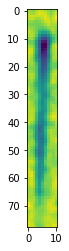

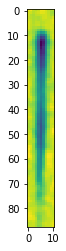

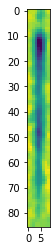

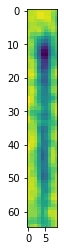

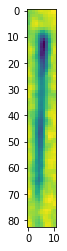

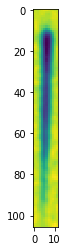

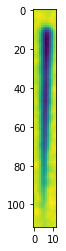

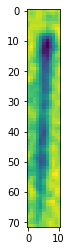

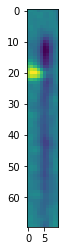

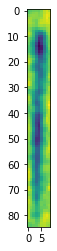

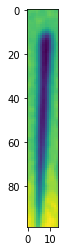

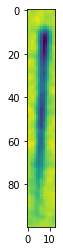

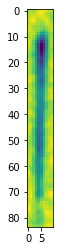

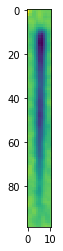

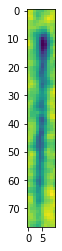

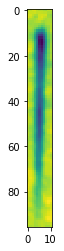

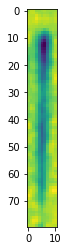

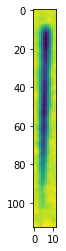

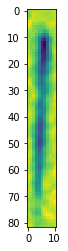

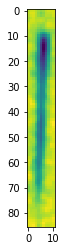

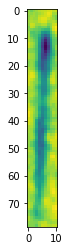

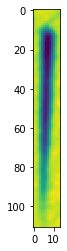

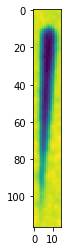

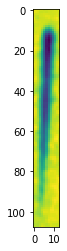

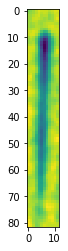

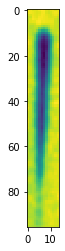

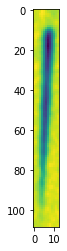

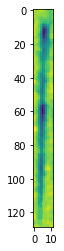

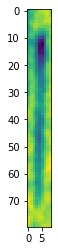

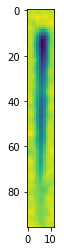

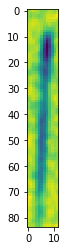

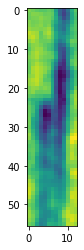

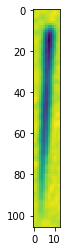

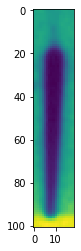

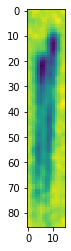

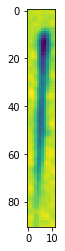

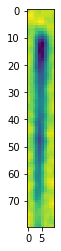

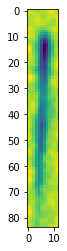

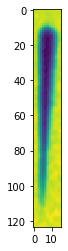

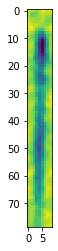

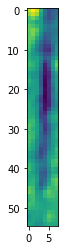

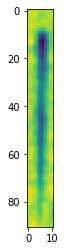

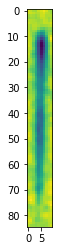

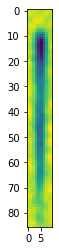

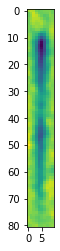

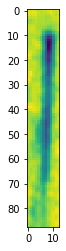

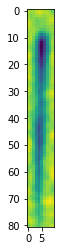

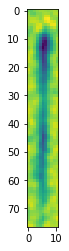

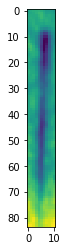

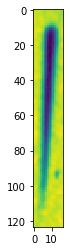

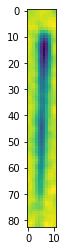

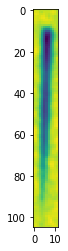

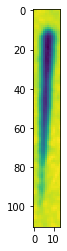

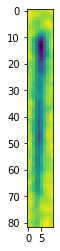

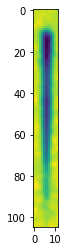

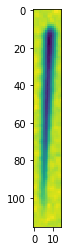

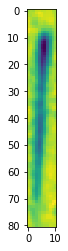

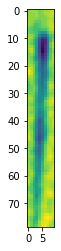

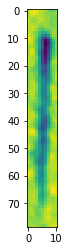

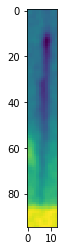

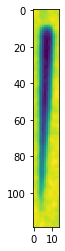

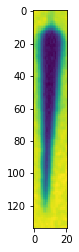

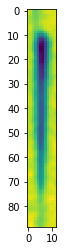

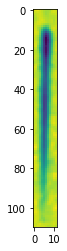

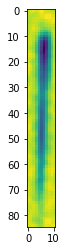

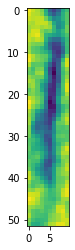

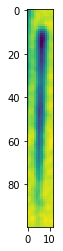

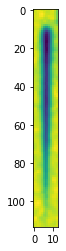

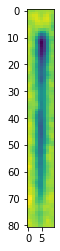

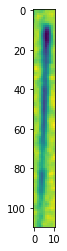

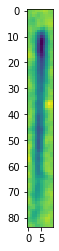

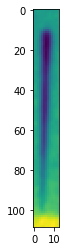

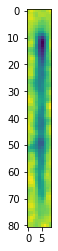

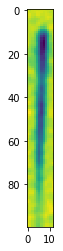

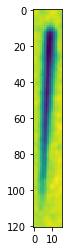

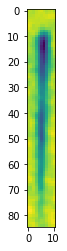

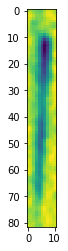

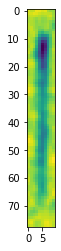

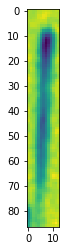

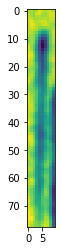

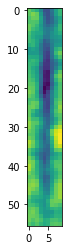

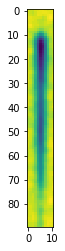

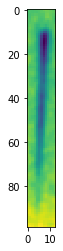

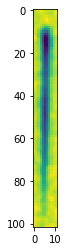

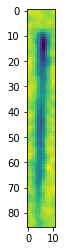

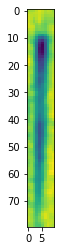

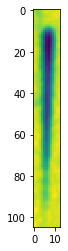

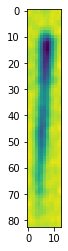

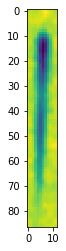

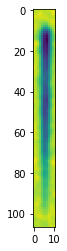

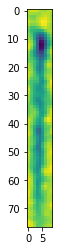

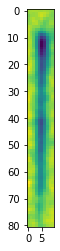

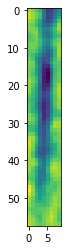

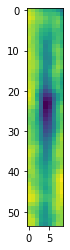

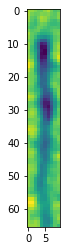

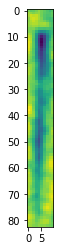

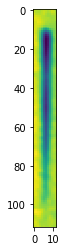

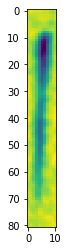

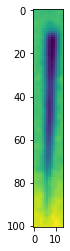

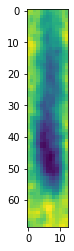

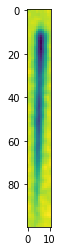

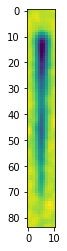

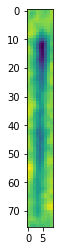

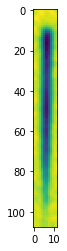

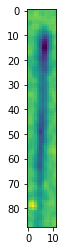

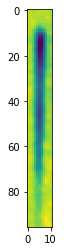

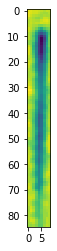

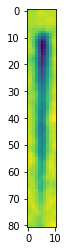

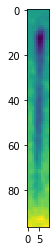

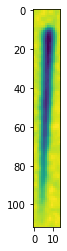

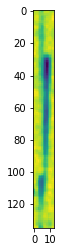

KeyboardInterrupt: 

In [231]:
for index, row in df_files.iterrows():
    file_path = row["file_name"]
    f = file_path.split('/')
    fp = "./obj_test_res/"+f[3]
    #print(file_path)
    
    try:
        im = Image.open(fp)
        #im.save("./Clusters/7/"+f[3])
    except:
        print("err")
        
    plt.imshow(im)
    plt.show()
    #break
    #print(row['file_name'])